## PUR Calculation Process by BSJ

### Process list
1. [Import libaray](#1.Import_libaray)
2. [Data Preprocessing](#2.Data_Preprocessing)
3. [Data Z-score conversion](#3.Data_Z-score_conversion)
4. [Normality test by P/F](#4.Normality_test_by_P/F)
5. [Check data distribution by KDE and PDF](#5.Check_data_distribution_by_KDE_and_PDF)
6. [PUR calculation by KDE and PDF](#6.PUR_calculation_by_KDE_and_PDF)

#### 1.Import_libaray

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import scipy.stats as stats
import seaborn as sns
warnings.simplefilter("ignore")
import scipy.stats as st
from scipy.stats import shapiro, norm, gaussian_kde
from statsmodels.graphics.gofplots import qqplot, ProbPlot
import scipy.integrate as integrate

In [3]:
''' Function Declaration Collection For Graph setting'''
# Graph Font setting
def setGraphFont():
    import matplotlib.font_manager as fm

    # 설치된 폰트 출력
    font_list = [font.name for font in fm.fontManager.ttflist]

    # default font 설정
    plt.rcParams['font.family'] = font_list[np.min([i for i in range(len(font_list)) if 'Times New Roman' in font_list[i]])]  # -12 : Times New Roman, -14 : Nanum gothic
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1.5
    plt.rc("axes", unicode_minus=False)

    # Configure rcParams axes.prop_cycle to simultaneously cycle cases and colors.
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
setGraphFont()

#### 2.Data_Preprocessing

##### EIS Data Preprocessing

In [16]:
# Load EIS Raw Data
eis_raw_df = pd.read_csv("./Raw_data/03-02 DS03 RDF - PassFail Discrimination V0.0 240910.csv")
eis_raw_df["P/F"] = eis_raw_df["P/F"].replace({"P":1, "F":0})
eis_raw_df.drop(columns=["ITER"], inplace=True)

In [17]:
# Remove outlier NC01,NC02,NC03,
Cell_name = eis_raw_df["Cell Name"].unique()
eis_raw_df = eis_raw_df.drop(index=eis_raw_df[eis_raw_df["Cell Name"].isin(["NC01", "NC02", "NC03"])].index, inplace=False).reset_index(drop=True)
eis_raw_df = eis_raw_df[eis_raw_df["Freq"].isin([1000.0, 10.0, 100.0, 1.0])].reset_index(drop=True)

##### DRT Data Preprocessing

In [18]:
# Load DRT Raw data
drt_path = os.getcwd()+"./Raw_data/DRT_data"
drt_flist = os.listdir(drt_path)
drt_flist = [i for i in drt_flist if not any(exclude in i for exclude in ["NC01", "NC02", "NC03"])]
drt_list = []
for file in range(len(drt_flist)):
    drt_data = pd.read_csv(drt_path + "/" + "".join(drt_flist[file]), skiprows=2).reset_index(drop=True)
    file_name = drt_flist[file].split("_")[0]
    max_gamma = drt_data["gamma"].max()
    drt_list.append([file_name, max_gamma])
drt_df = pd.DataFrame(drt_list, columns=["Cell Name", "Max Gamma"])
len(drt_df)

52

##### Mergy EIS and DRT Data for P/F DataFram

In [20]:
# Set P/F Cell DataFrame
pf_raw_df = {}
col_ord = ["Cell Name", "Freq", "Zre (mohm)", "Zim (mohm)", "Mag (mohm)", "Phase", "P/F", "OCV-B", "Max Gamma"]
Freq_list = [1.0, 10.0, 100.0, 1000.0]
for fre in Freq_list:
    pf_raw_df[f'F_{fre}'] = eis_raw_df[eis_raw_df["Freq"]==fre].reset_index(drop=True)
    pf_raw_df[f'F_{fre}'] = pd.merge(pf_raw_df[f'F_{fre}'], drt_df, on='Cell Name', how='inner')[col_ord]

#### 3.Data_Z-score_conversion

##### inf DataFrame conversion (inf : independent frequency -> OCV, DRT)

In [22]:
# Set OCV, DRT DataFrame : independent Frequency
f_df_list = list(pf_raw_df.keys())
in_f_df = pf_raw_df[f_df_list[0]][["Cell Name", "P/F", "OCV-B", "Max Gamma"]]


# Make Transfer to Z_score DataFrame
# OCV, DRT
inf_cols = ["OCV-B", "Max Gamma"]
dummy_snd_inf = in_f_df[inf_cols]
dummy_snd_inf = ((dummy_snd_inf - dummy_snd_inf.mean()) / dummy_snd_inf.std())
org_inf_df = in_f_df[["Cell Name", "P/F"]]
snd_inf_df = pd.concat([org_inf_df, dummy_snd_inf], axis=1)

##### EIS Features DataFrame conversion


In [23]:
# EIS Features
eis_ft_cols = ["Zre (mohm)", "Zim (mohm)", "Mag (mohm)", "Phase"]
snd_df = {}
for f in f_df_list:
    dummy = pf_raw_df[f][eis_ft_cols]
    dummy = ((dummy - dummy.mean()) / dummy.std())
    org_dummy_df = pf_raw_df[f][[pf_raw_df[f].columns[0], pf_raw_df[f].columns[1], pf_raw_df[f].columns[6]]]
    snd_df[f] = pd.concat([org_dummy_df, dummy], axis=1)

#### 4.Normality_test_by_P/F

##### inf DataFrame Normality Test

In [24]:
# Normality Test of OCV, DRT
norm_ind_df_p, norm_ind_df_f = [], []
shapiro_ind_df_p = in_f_df[in_f_df["P/F"] == 1]
for column in inf_cols:
    stat, p_value = shapiro(shapiro_ind_df_p[column])
    skewness = shapiro_ind_df_p[column].skew()
    Kurtosis = shapiro_ind_df_p[column].kurtosis()
    # print(f, column, stat, p_value)
    norm_ind_df_p.append({'Feature': column, 'Shapiro Stat': stat, 'p-value': p_value, 'skewness': skewness, 'Kurtosis': Kurtosis})

shapiro_ind_df_f = in_f_df[in_f_df["P/F"] == 0]
for column in inf_cols:
    stat, p_value = shapiro(shapiro_ind_df_f[column])
    skewness = shapiro_ind_df_f[column].skew()
    Kurtosis = shapiro_ind_df_f[column].kurtosis()
    # print(f, column, stat, p_value)
    norm_ind_df_f.append({'Feature': column, 'Shapiro Stat': stat, 'p-value': p_value, 'skewness': skewness, 'Kurtosis': Kurtosis})
shapiro_norm_ind_df_p = pd.DataFrame(norm_ind_df_p)
shapiro_norm_ind_df_f = pd.DataFrame(norm_ind_df_f)

##### EIS Features DataFrame Normality  Test

In [25]:

# Normality Test of EIS Features
norm_eis_df_p, norm_eis_df_f = [], []
for f in f_df_list:
    shapiro_eis_df_p = pf_raw_df[f][pf_raw_df[f]["P/F"] == 1]
    for column in eis_ft_cols:
        stat, p_value = shapiro(shapiro_eis_df_p[column])
        skewness = shapiro_eis_df_p[column].skew()
        Kurtosis = shapiro_eis_df_p[column].kurtosis()
        # print(f, column, stat, p_value)
        norm_eis_df_p.append({'Frequency': f, 'Feature': column, 'Shapiro Stat': stat, 'p-value': p_value, 'skewness': skewness, 'Kurtosis': Kurtosis})

    shapiro_eis_df_f = pf_raw_df[f][pf_raw_df[f]["P/F"] == 0]
    for column in eis_ft_cols:
        stat, p_value = shapiro(shapiro_eis_df_f[column])
        skewness = shapiro_eis_df_f[column].skew()
        Kurtosis = shapiro_eis_df_f[column].kurtosis()
        # print(f, column, stat, p_value)
        norm_eis_df_f.append({'Frequency': f, 'Feature': column, 'Shapiro Stat': stat, 'p-value': p_value, 'skewness': skewness, 'Kurtosis': Kurtosis})
shapiro_norm_eis_df_p = pd.DataFrame(norm_eis_df_p)
shapiro_norm_eis_df_f = pd.DataFrame(norm_eis_df_f)
shapiro_norm_eis_df_p[shapiro_norm_eis_df_p["p-value"]<0.05]

,Frequency,Feature,Shapiro Stat,p-value,skewness,Kurtosis
7,F_10.0,Phase,0.932780,0.027328,0.918403,1.988434
13,F_1000.0,Zim (mohm),0.900633,0.003069,0.983304,0.205417
14,F_1000.0,Mag (mohm),0.896640,0.002380,0.951385,-0.017183


##### QQ plot

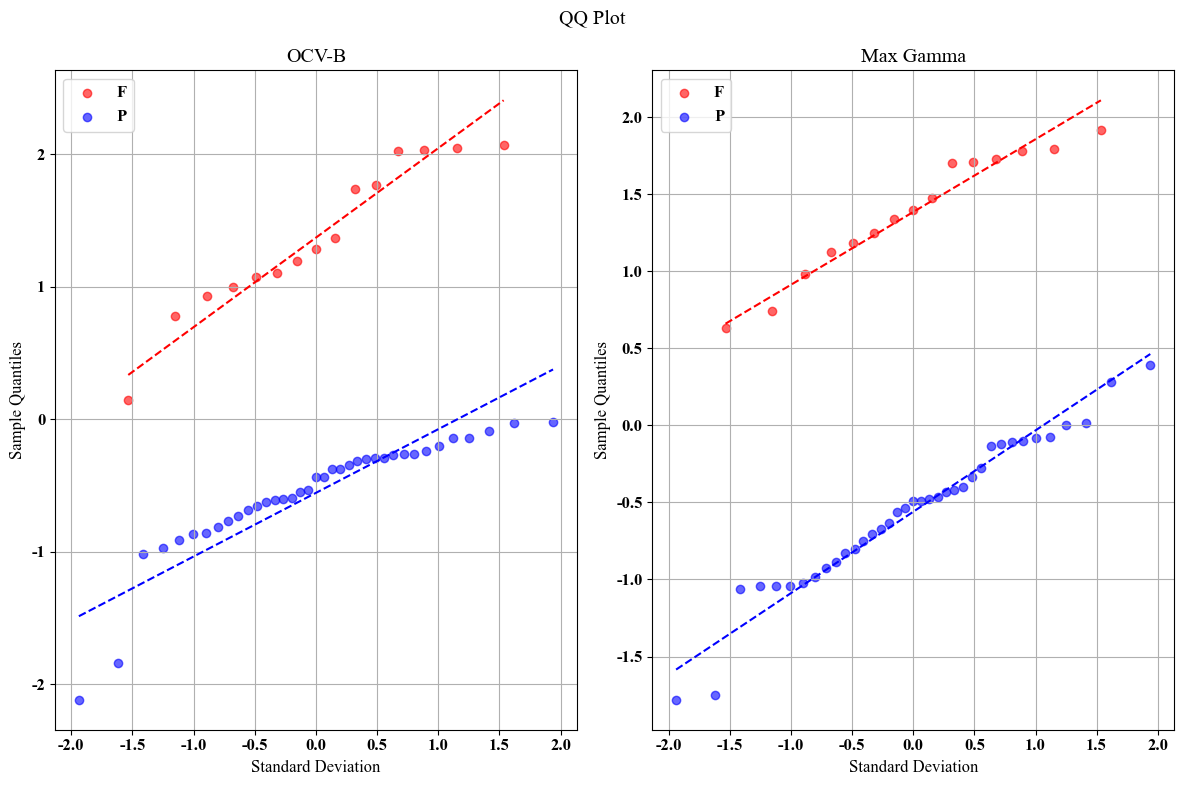

In [26]:
# QQ-Plot of OCV, DRT
sdf_draw_inf_df_0 = snd_inf_df[snd_inf_df["P/F"] == 0]
sdf_draw_inf_df_1 = snd_inf_df[snd_inf_df["P/F"] == 1]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
fig.suptitle("QQ Plot")
for i, ft in enumerate(inf_cols):
    dummy_draw_0 = sdf_draw_inf_df_0[ft]  # P/F == 0 데이터
    dummy_draw_1 = sdf_draw_inf_df_1[ft]  # P/F == 1 데이터
    ax = ax.flatten()
    # P/F == 0인 데이터에 대한 QQ 플롯 (빨간색)
    probplot_0 = ProbPlot(dummy_draw_0)
    mean_0 = dummy_draw_0.mean()
    std_0 = dummy_draw_0.std()
    ax[i].scatter(probplot_0.theoretical_quantiles, probplot_0.sample_quantiles, color='red', alpha=0.6,label="F")
    ax[i].plot(probplot_0.theoretical_quantiles, mean_0 + std_0 * probplot_0.theoretical_quantiles / probplot_0.theoretical_quantiles.std(),'r--')
    # P/F == 1인 데이터에 대한 QQ 플롯 (파란색)
    probplot_1 = ProbPlot(dummy_draw_1)
    mean_1 = dummy_draw_1.mean()
    std_1 = dummy_draw_1.std()
    ax[i].scatter(probplot_1.theoretical_quantiles, probplot_1.sample_quantiles, color='blue', alpha=0.6,label="P")
    ax[i].plot(probplot_1.theoretical_quantiles, mean_1 + std_1 * probplot_1.theoretical_quantiles / probplot_1.theoretical_quantiles.std(),'b--')
    # 레이블 및 범례 설정
    ax[i].set_title(ft)
    ax[i].set_xlabel("Standard Deviation")
    ax[i].set_ylabel('Sample Quantiles')
    ax[i].legend()
plt.tight_layout()

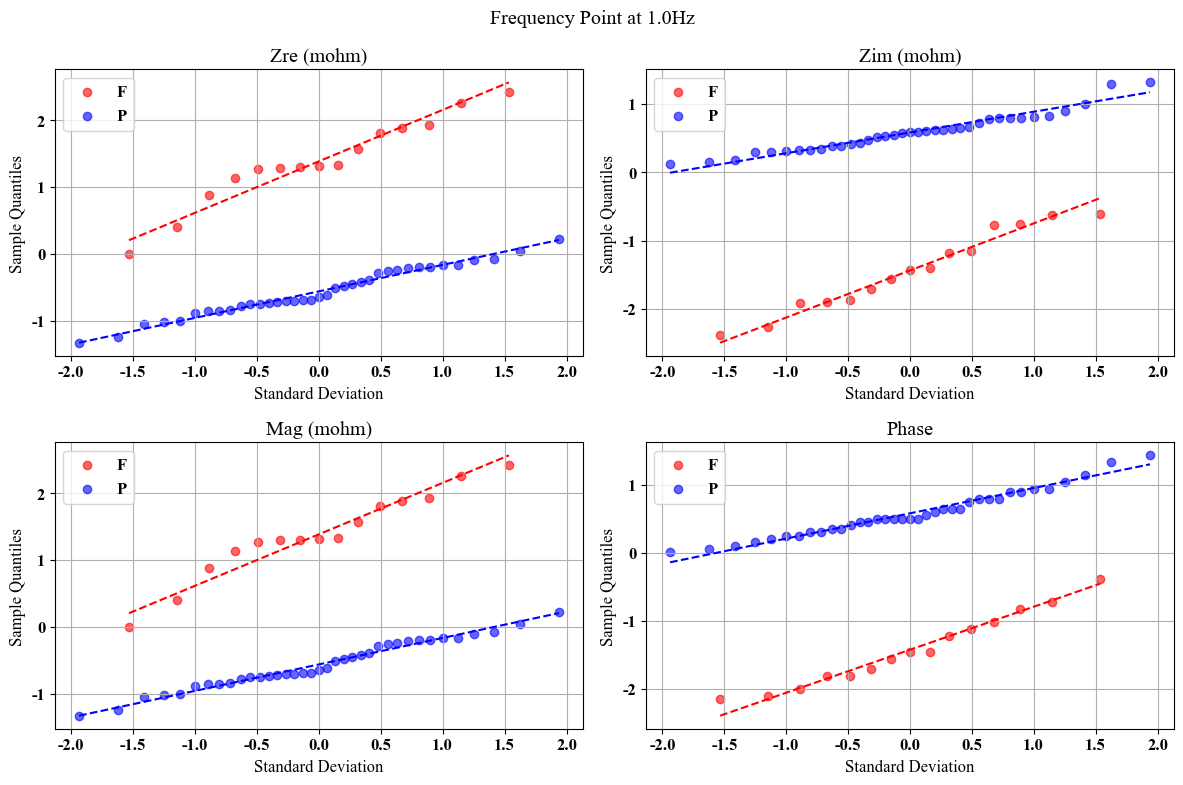

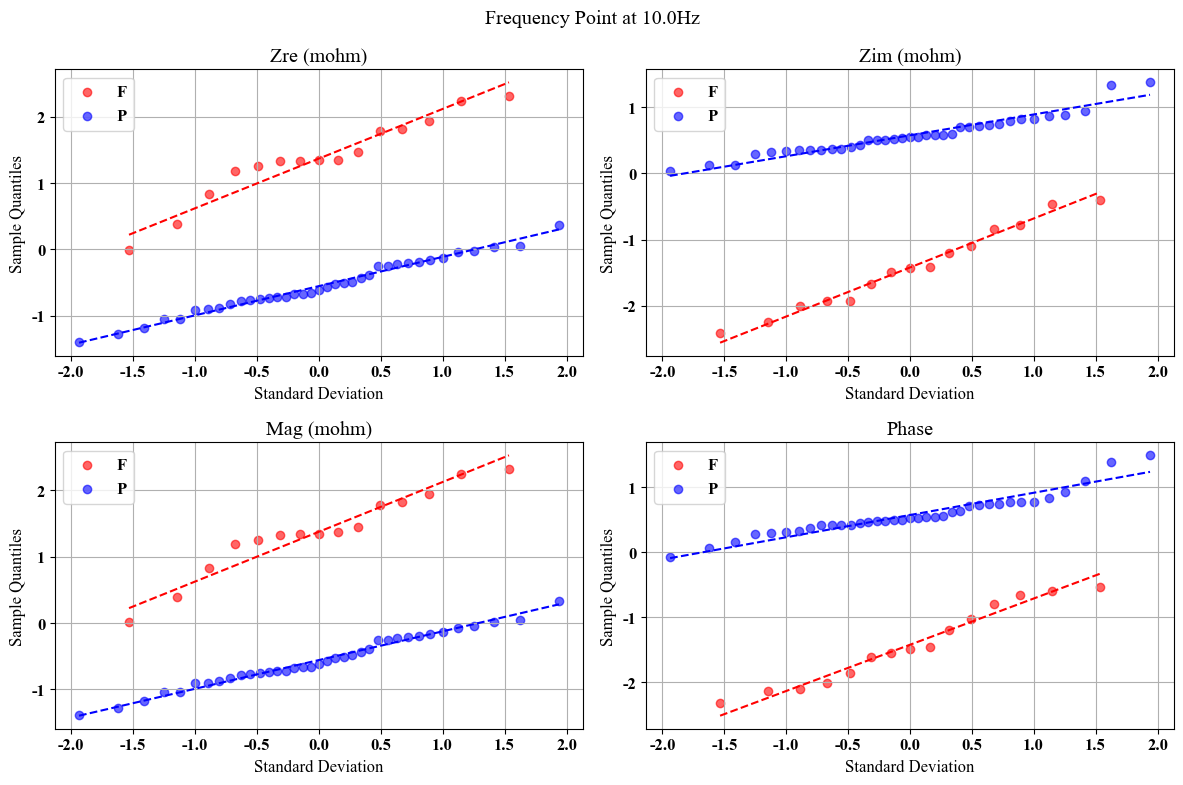

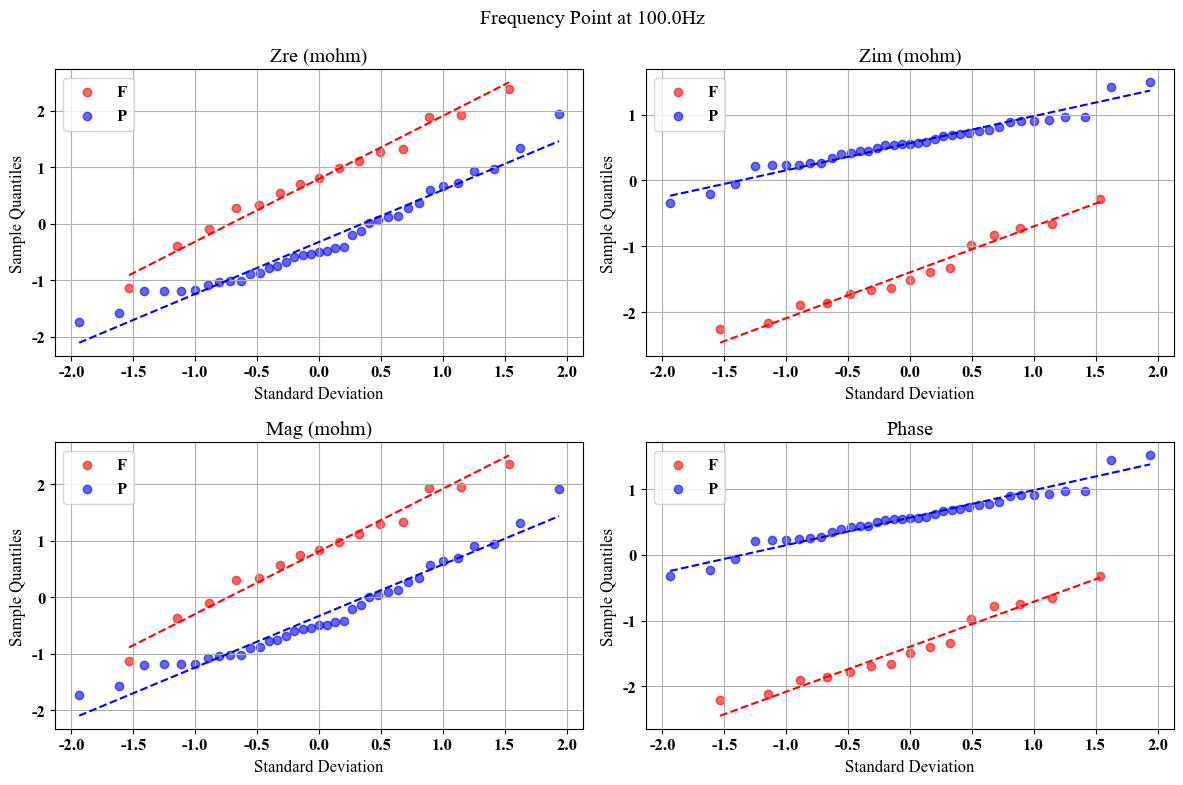

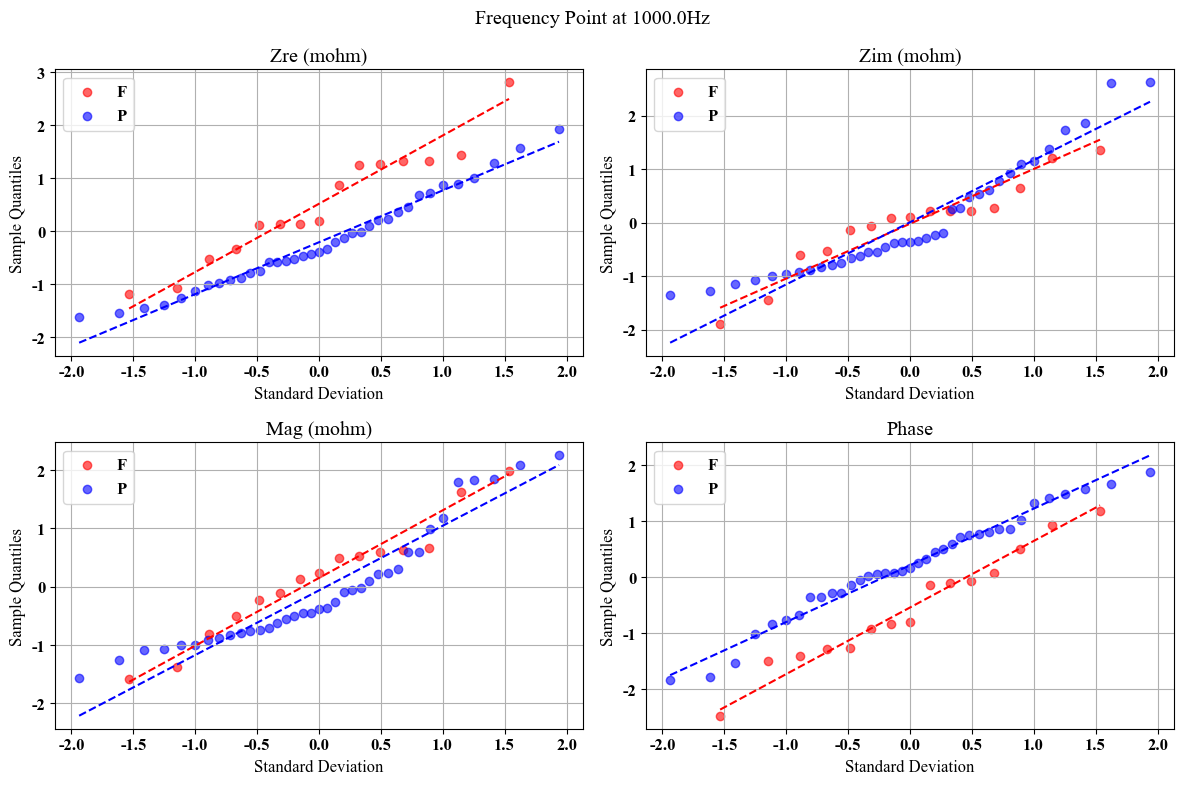

In [27]:
# QQ-Plot of EIS Features
for f in f_df_list:
    sdf_draw_eis_df_0 = snd_df[f][snd_df[f]["P/F"] == 0]  # P/F == 0
    sdf_draw_eis_df_1 = snd_df[f][snd_df[f]["P/F"] == 1]  # P/F == 1
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    fig.suptitle('Frequency Point at ' + str(f[2:]) + "Hz")
    for i, ft in enumerate(eis_ft_cols):
        dummy_draw_0 = sdf_draw_eis_df_0[ft]  # P/F == 0 데이터
        dummy_draw_1 = sdf_draw_eis_df_1[ft]  # P/F == 1 데이터
        row = int(i / 2)
        col = i % 2
        # P/F == 0인 데이터에 대한 QQ 플롯 (빨간색)
        probplot_0 = ProbPlot(dummy_draw_0)
        mean_0 = dummy_draw_0.mean()
        std_0 = dummy_draw_0.std()
        axs[row][col].scatter(probplot_0.theoretical_quantiles, probplot_0.sample_quantiles, color='red', alpha=0.6,label="F")
        axs[row][col].plot(probplot_0.theoretical_quantiles, mean_0 + std_0 * probplot_0.theoretical_quantiles / probplot_0.theoretical_quantiles.std(),'r--')
        # P/F == 1인 데이터에 대한 QQ 플롯 (파란색)
        probplot_1 = ProbPlot(dummy_draw_1)
        mean_1 = dummy_draw_1.mean()
        std_1 = dummy_draw_1.std()
        axs[row][col].scatter(probplot_1.theoretical_quantiles, probplot_1.sample_quantiles, color='blue', alpha=0.6,label="P")
        axs[row][col].plot(probplot_1.theoretical_quantiles, mean_1 + std_1 * probplot_1.theoretical_quantiles / probplot_1.theoretical_quantiles.std(),'b--')
        # 레이블 및 범례 설정
        axs[row][col].set_title(ft)
        axs[row][col].set_xlabel("Standard Deviation")
        axs[row][col].set_ylabel('Sample Quantiles')
        axs[row][col].legend()
    plt.tight_layout()

#### 5.Check_data_distribution_by_KDE_and_PDF

##### KDE(Kernel Density Estimation)

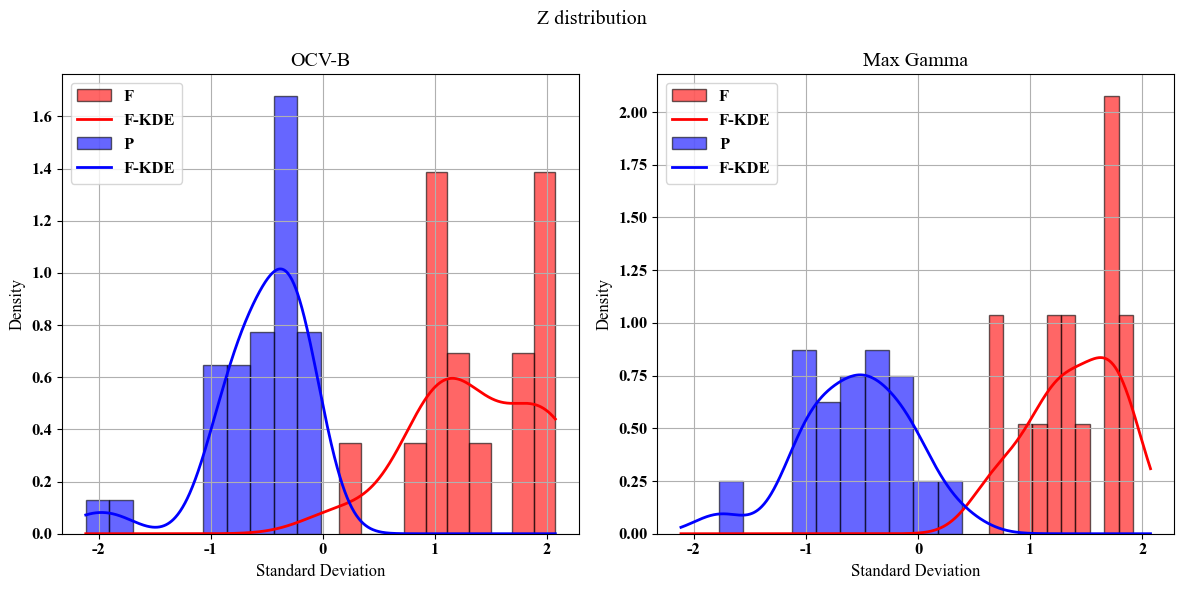

In [ ]:
# Z Distribution of OCV, DRT
sdf_draw_inf_df_0 = snd_inf_df[snd_inf_df["P/F"] == 0]
sdf_draw_inf_df_1 = snd_inf_df[snd_inf_df["P/F"] == 1]

sdf_draw_inf_df_0_numeric = sdf_draw_inf_df_0.select_dtypes(include=[np.number]).drop(["P/F"], axis=1)
sdf_draw_inf_df_1_numeric = sdf_draw_inf_df_1.select_dtypes(include=[np.number]).drop(["P/F"], axis=1)

min_val = min(sdf_draw_inf_df_0_numeric.min().min(), sdf_draw_inf_df_1_numeric.min().min())
max_val = max(sdf_draw_inf_df_0_numeric.max().max(), sdf_draw_inf_df_1_numeric.max().max())

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
fig.suptitle('Z distribution')
for i, ft in enumerate(inf_cols):
    dummy_draw_0 = sdf_draw_inf_df_0[ft]
    dummy_draw_1 = sdf_draw_inf_df_1[ft]
    ax = ax.flatten()
    row = int(i / 2)
    col = i % 2
    # KDE plot for P/F == 0
    kde_0 = gaussian_kde(dummy_draw_0)
    x_vals_0 = np.linspace(min_val, max_val, 1000)
    # KDE plot for P/F == 1
    kde_1 = gaussian_kde(dummy_draw_1)
    x_vals_1 = np.linspace(min_val, max_val, 1000)
    # Plot histogram and KDE for P/F == 0 (blue color)
    ax[i].hist(dummy_draw_0, bins=10, color='red', edgecolor='black', density=True, alpha=0.6,label="F")
    ax[i].plot(x_vals_0, kde_0(x_vals_0), color='red', lw=2, label="F-KDE")
    # Plot histogram and KDE for P/F == 1 (red color)
    ax[i].hist(dummy_draw_1, bins=10, color='blue', edgecolor='black', density=True, alpha=0.6,label="P")
    ax[i].plot(x_vals_1, kde_1(x_vals_1), color='blue', lw=2, label="F-KDE")
    # 레이블 설정
    ax[i].set_title(ft)
    ax[i].set_xlabel("Standard Deviation")
    ax[i].set_ylabel('Density')
    ax[i].legend()
plt.tight_layout()

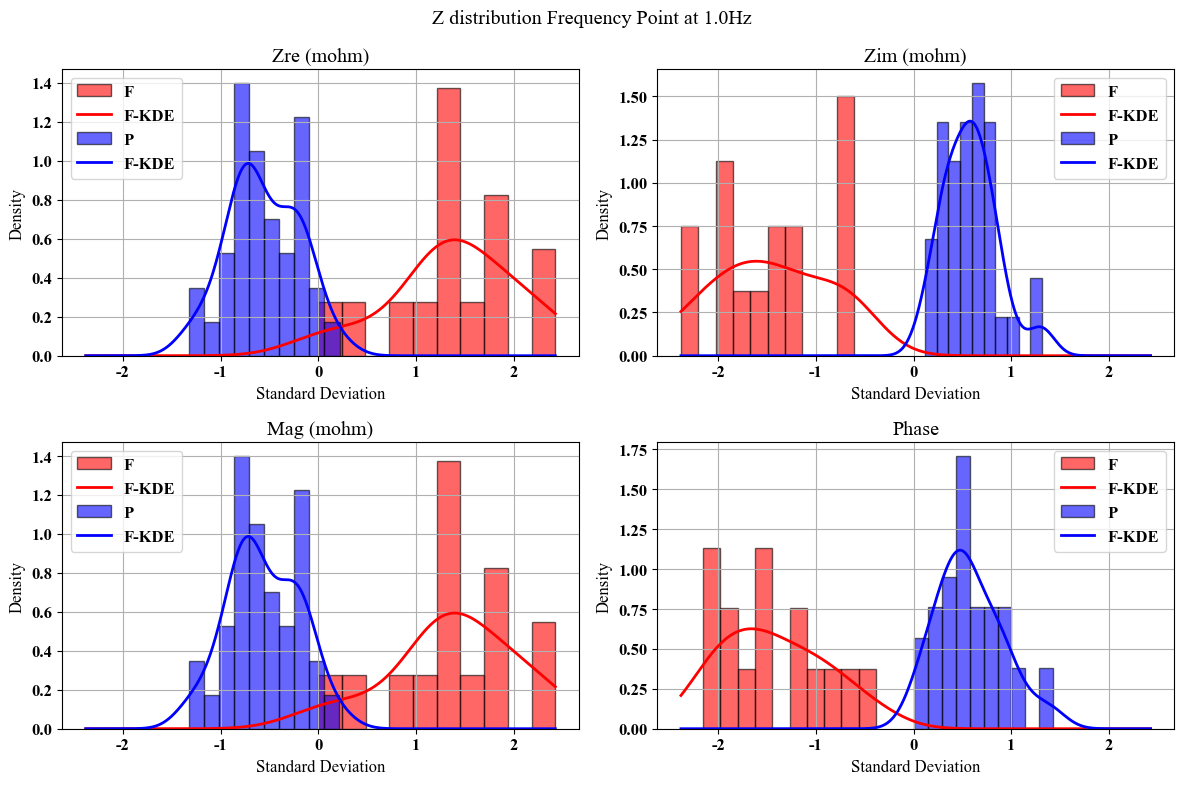

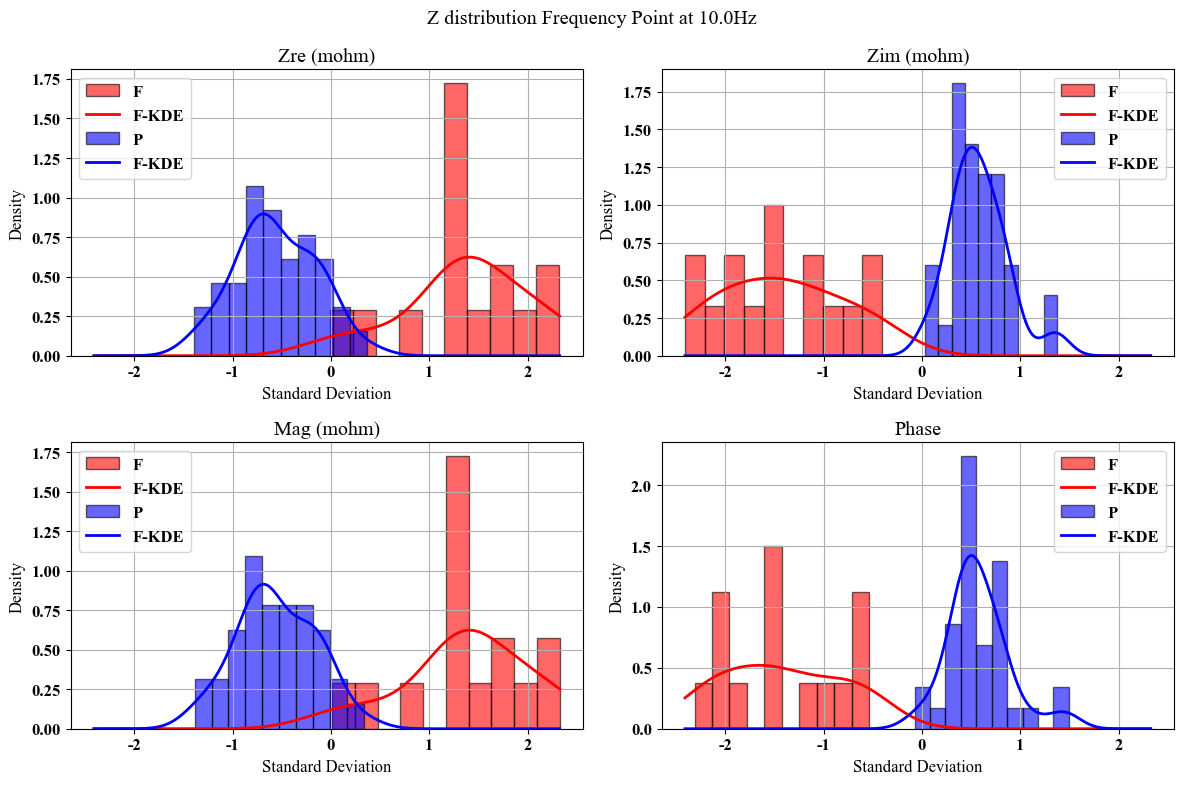

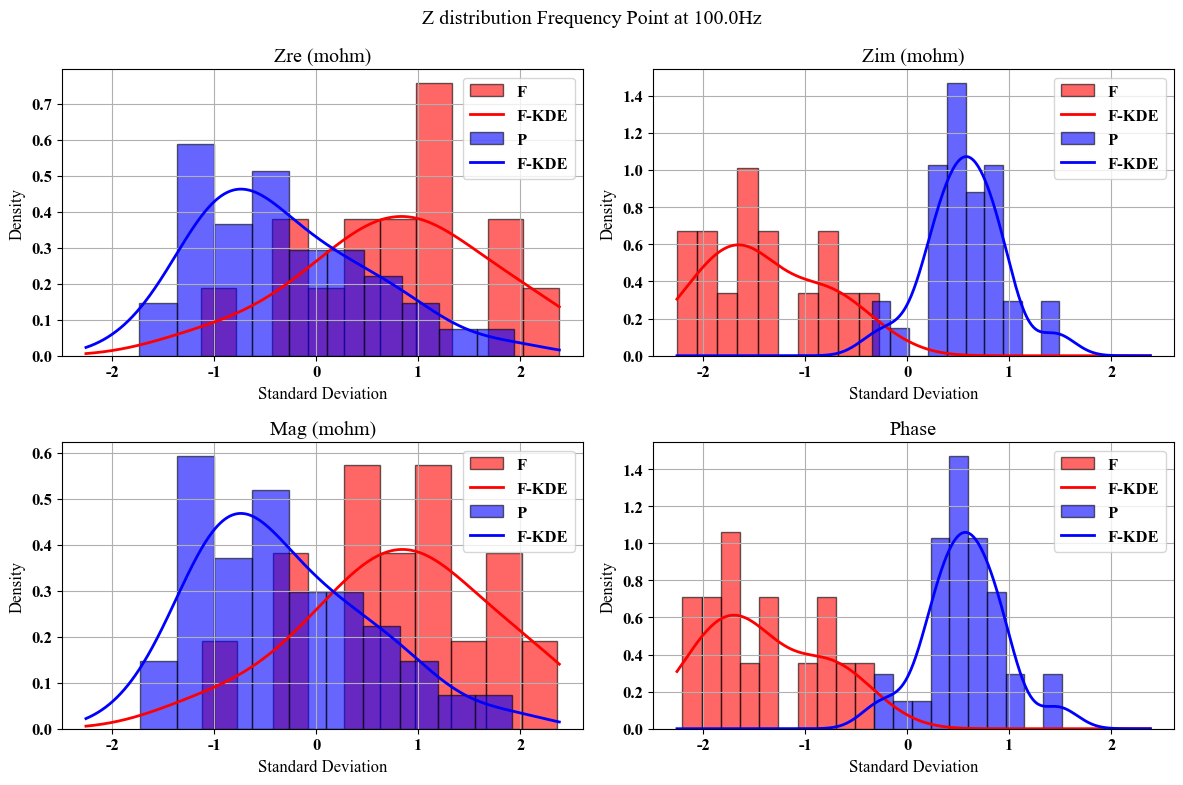

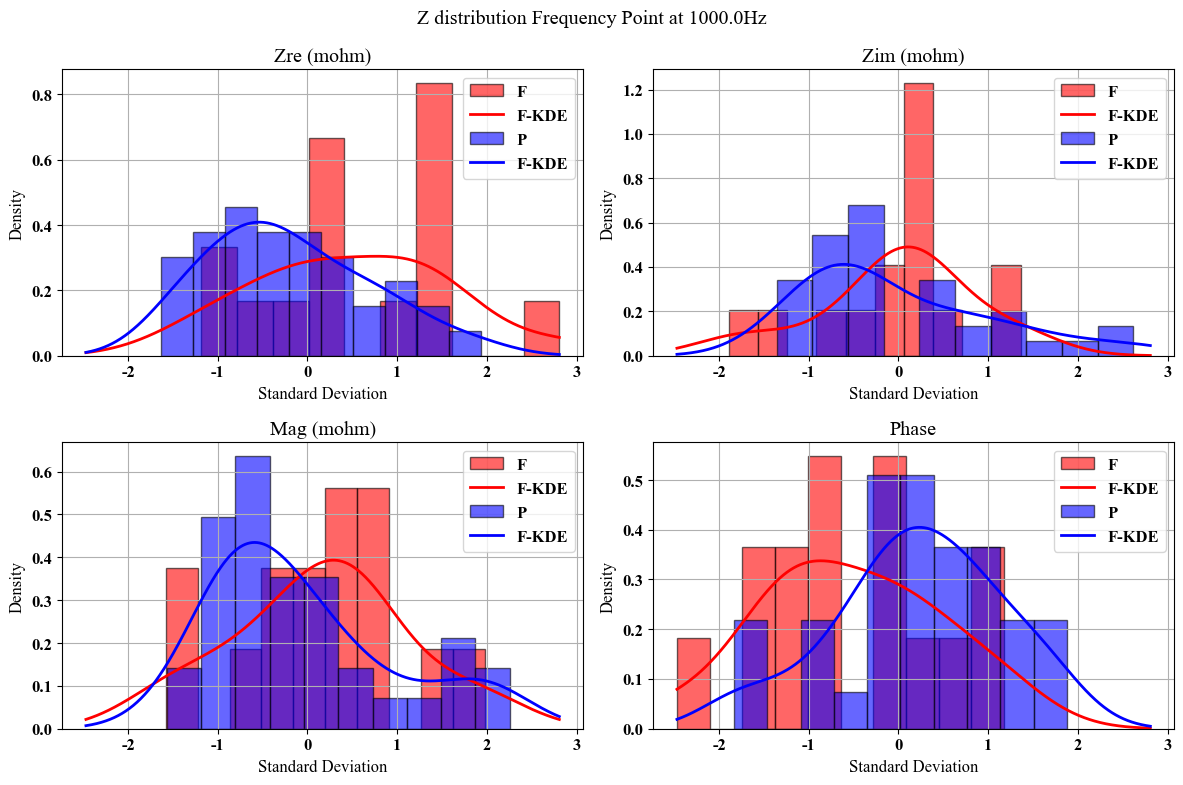

In [29]:
# Z Distribution of EIS-Features
for f in f_df_list:
    sdf_draw_eis_df_0 = snd_df[f][snd_df[f]["P/F"] == 0]
    sdf_draw_eis_df_1 = snd_df[f][snd_df[f]["P/F"] == 1]

    sdf_draw_eis_df_0_numeric = sdf_draw_eis_df_0.select_dtypes(include=[np.number]).drop(["Freq", "P/F"], axis=1)
    sdf_draw_eis_df_1_numeric = sdf_draw_eis_df_1.select_dtypes(include=[np.number]).drop(["Freq", "P/F"], axis=1)

    min_val = min(sdf_draw_eis_df_0_numeric.min().min(), sdf_draw_eis_df_1_numeric.min().min())
    max_val = max(sdf_draw_eis_df_0_numeric.max().max(), sdf_draw_eis_df_1_numeric.max().max())
    # bins = np.linspace(min_val, max_val, 30)

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    fig.suptitle('Z distribution Frequency Point at ' + str(f[2:]) + "Hz")
    for i, ft in enumerate(eis_ft_cols):
        dummy_draw_0 = sdf_draw_eis_df_0[ft]
        dummy_draw_1 = sdf_draw_eis_df_1[ft]
        row = int(i / 2)
        col = i % 2
        # KDE plot for P/F == 0
        kde_0 = gaussian_kde(dummy_draw_0)
        x_vals_0 = np.linspace(min_val, max_val, 1000)
        # KDE plot for P/F == 1
        kde_1 = gaussian_kde(dummy_draw_1)
        x_vals_1 = np.linspace(min_val, max_val, 1000)
        # Plot histogram and KDE for P/F == 0 (blue color)
        axs[row][col].hist(dummy_draw_0, bins=10, color='red', edgecolor='black', density=True, alpha=0.6,label="F")
        axs[row][col].plot(x_vals_0, kde_0(x_vals_0), color='red', lw=2, label="F-KDE")
        # Plot histogram and KDE for P/F == 1 (red color)
        axs[row][col].hist(dummy_draw_1, bins=10, color='blue', edgecolor='black', density=True, alpha=0.6,label="P")
        axs[row][col].plot(x_vals_1, kde_1(x_vals_1), color='blue', lw=2, label="F-KDE")
        # 레이블 설정
        axs[row][col].set_title(ft)
        axs[row][col].set_xlabel("Standard Deviation")
        axs[row][col].set_ylabel('Density')
        axs[row][col].legend()
    plt.tight_layout()  

##### PDF(Probability Density Function)

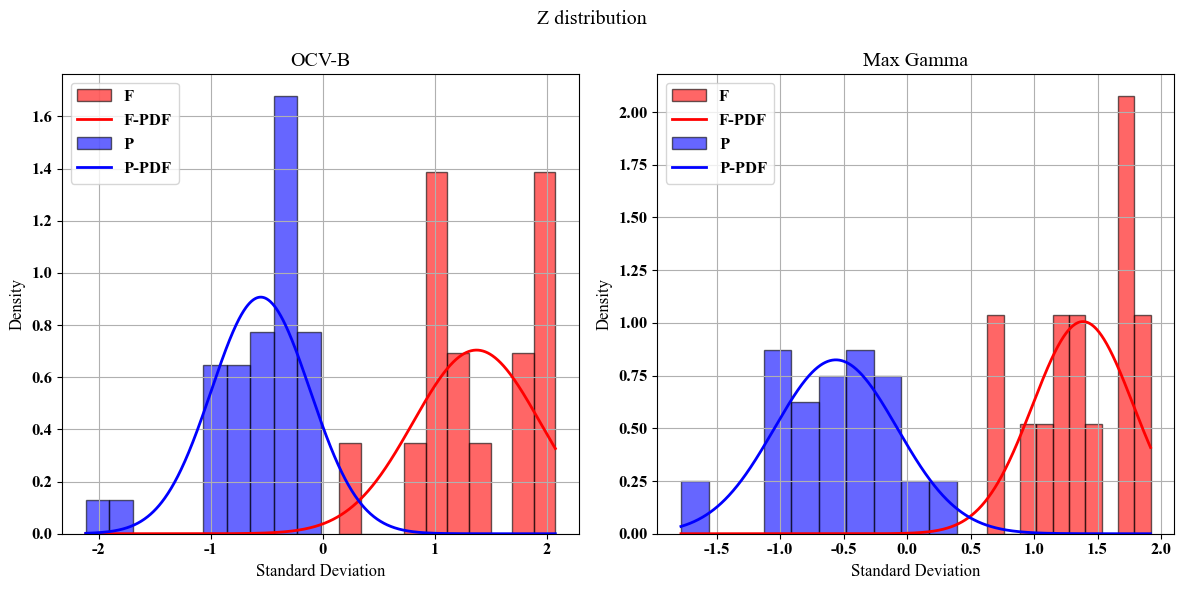

In [30]:
# Z Distribution of OCV, DRT
sdf_draw_inf_df_0 = snd_inf_df[snd_inf_df["P/F"] == 0]
sdf_draw_inf_df_1 = snd_inf_df[snd_inf_df["P/F"] == 1]

sdf_draw_inf_df_0_numeric = sdf_draw_inf_df_0.select_dtypes(include=[np.number]).drop(["P/F"], axis=1)
sdf_draw_inf_df_1_numeric = sdf_draw_inf_df_1.select_dtypes(include=[np.number]).drop(["P/F"], axis=1)

min_val = min(sdf_draw_inf_df_0_numeric.min().min(), sdf_draw_inf_df_1_numeric.min().min())
max_val = max(sdf_draw_inf_df_0_numeric.max().max(), sdf_draw_inf_df_1_numeric.max().max())

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
fig.suptitle('Z distribution')
# 각 Feature에 대해 처리
for i, ft in enumerate(inf_cols):
    dummy_draw_0 = sdf_draw_inf_df_0[ft]
    dummy_draw_1 = sdf_draw_inf_df_1[ft]
    # 플롯 배열 평탄화
    ax = ax.flatten()
    # X축 범위 설정
    min_val = min(dummy_draw_0.min(), dummy_draw_1.min())
    max_val = max(dummy_draw_0.max(), dummy_draw_1.max())
    x_vals = np.linspace(min_val, max_val, 1000)
    # PDF 계산
    pdf_0 = norm.pdf(x_vals, loc=dummy_draw_0.mean(), scale=dummy_draw_0.std())
    pdf_1 = norm.pdf(x_vals, loc=dummy_draw_1.mean(), scale=dummy_draw_1.std())
    # 히스토그램과 PDF 플롯
    ax[i].hist(dummy_draw_0, bins=10, color='red', edgecolor='black', density=True, alpha=0.6, label="F")
    ax[i].plot(x_vals, pdf_0, color='red', lw=2, label="F-PDF")
    ax[i].hist(dummy_draw_1, bins=10, color='blue', edgecolor='black', density=True, alpha=0.6, label="P")
    ax[i].plot(x_vals, pdf_1, color='blue', lw=2, label="P-PDF")
    # 레이블 설정
    ax[i].set_title(ft)
    ax[i].set_xlabel("Standard Deviation")
    ax[i].set_ylabel('Density')
    ax[i].legend()
# 레이아웃 설정
plt.tight_layout()

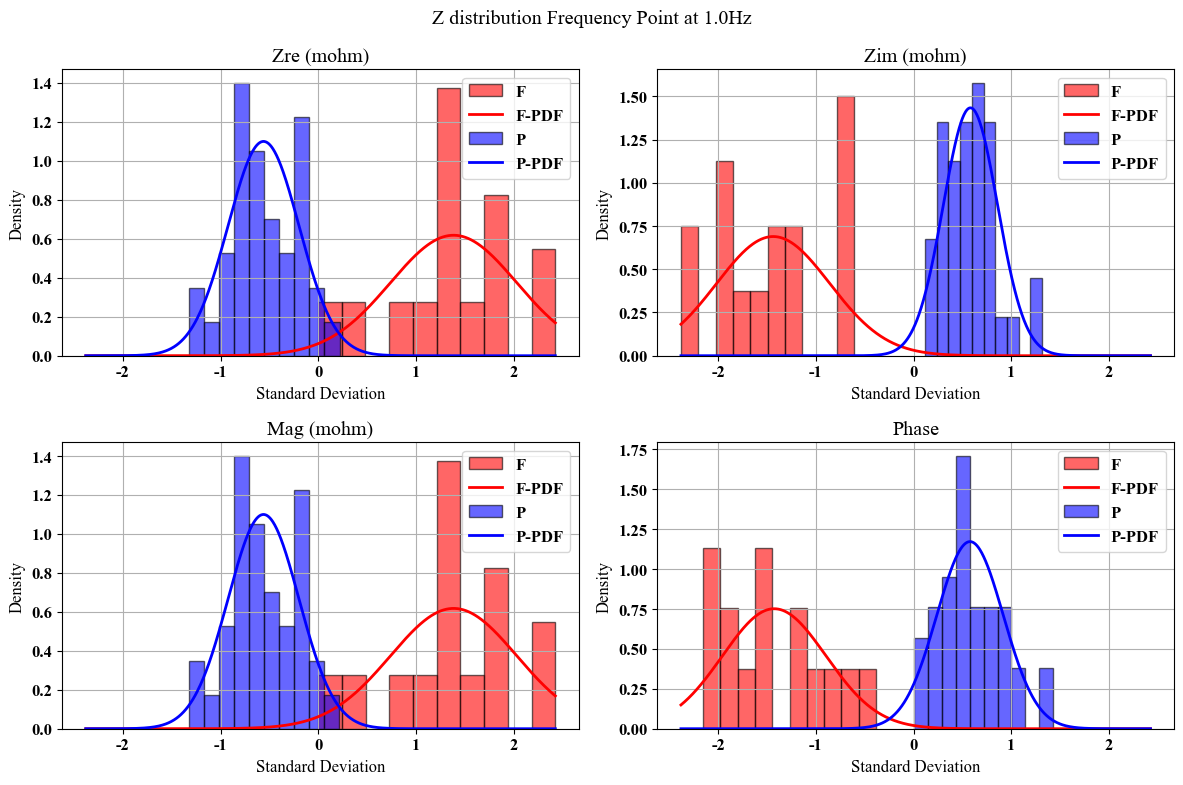

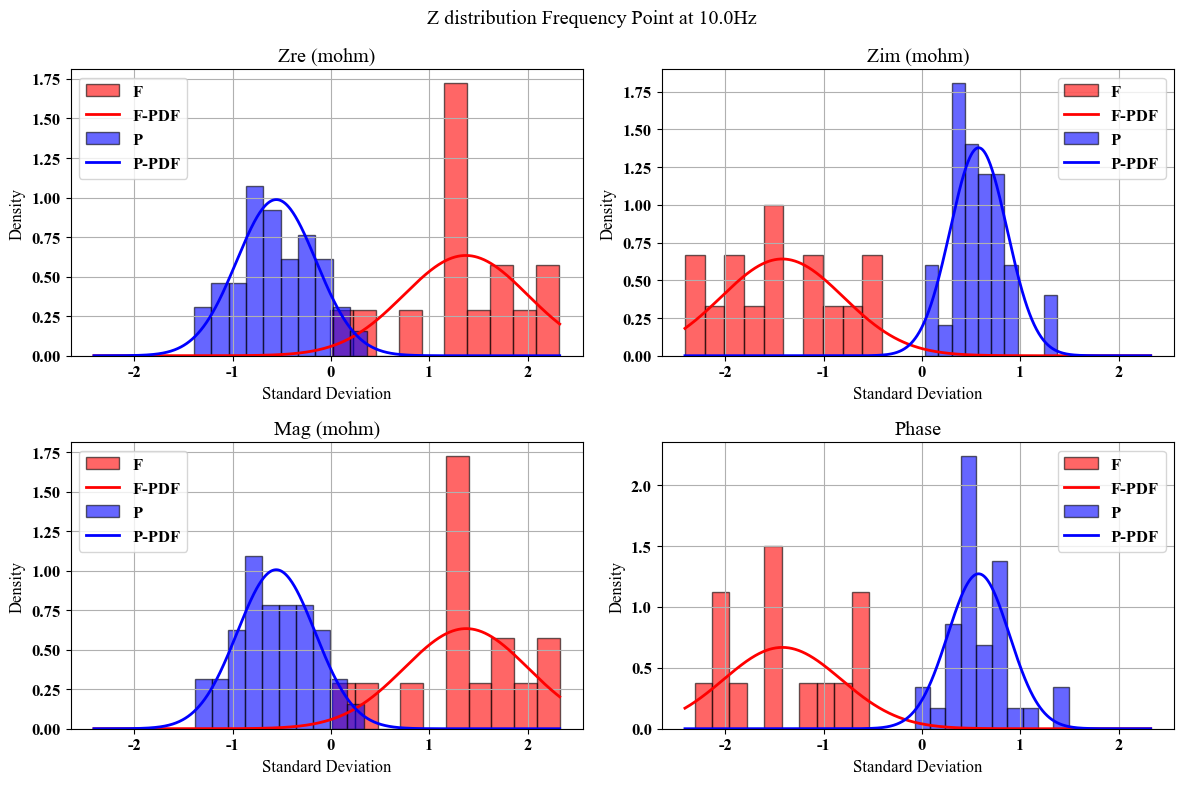

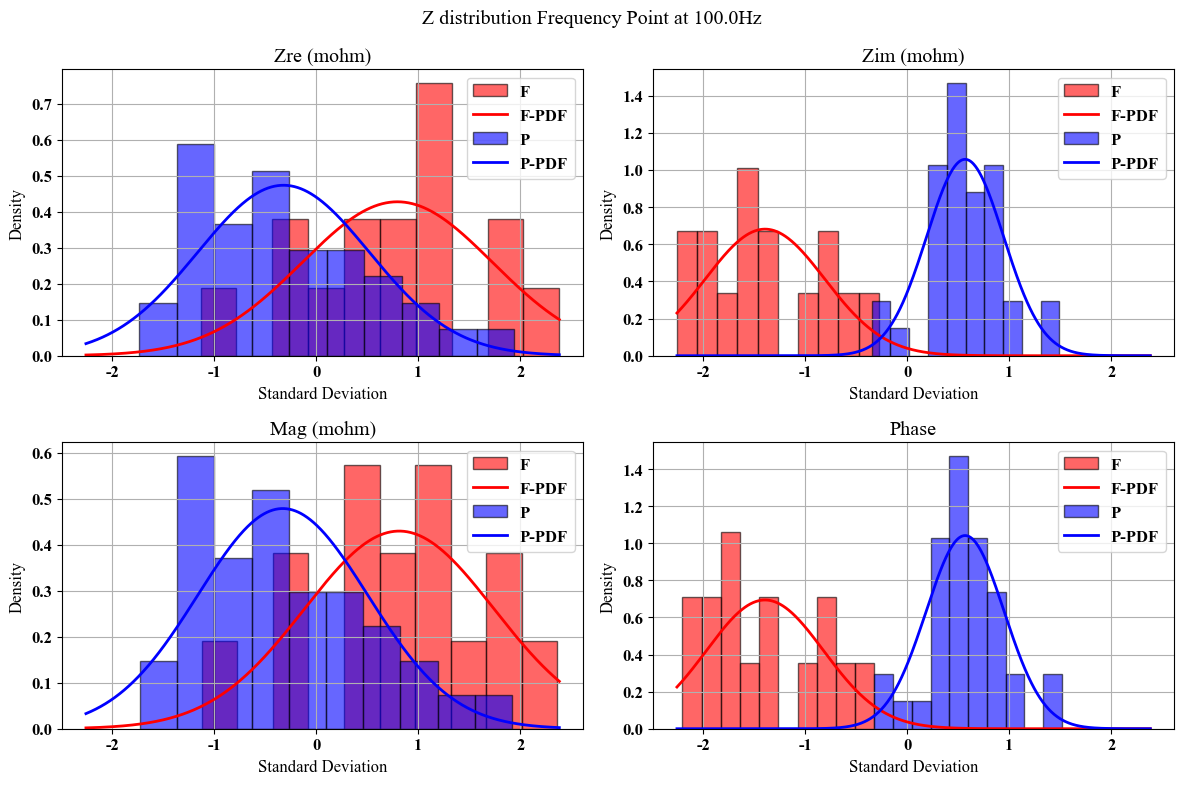

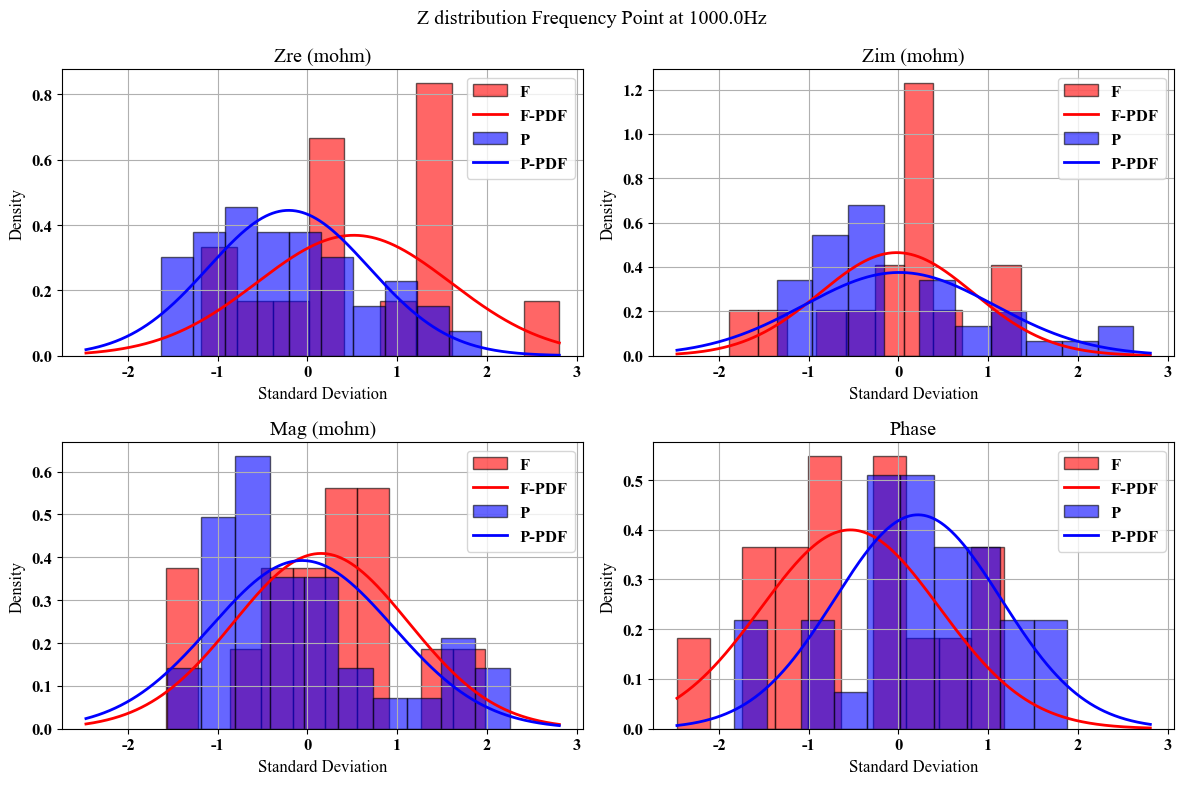

In [31]:
# Z Distribution of EIS-Features
for f in f_df_list:
    # P/F == 0과 P/F == 1로 데이터 분리
    sdf_draw_eis_df_0 = snd_df[f][snd_df[f]["P/F"] == 0]
    sdf_draw_eis_df_1 = snd_df[f][snd_df[f]["P/F"] == 1]

    # 숫자형 데이터만 추출
    sdf_draw_eis_df_0_numeric = sdf_draw_eis_df_0.select_dtypes(include=[np.number]).drop(["Freq", "P/F"], axis=1)
    sdf_draw_eis_df_1_numeric = sdf_draw_eis_df_1.select_dtypes(include=[np.number]).drop(["Freq", "P/F"], axis=1)

    # 데이터 범위 설정
    min_val = min(sdf_draw_eis_df_0_numeric.min().min(), sdf_draw_eis_df_1_numeric.min().min())
    max_val = max(sdf_draw_eis_df_0_numeric.max().max(), sdf_draw_eis_df_1_numeric.max().max())

    # 플롯 생성
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    fig.suptitle('Z distribution Frequency Point at ' + str(f[2:]) + "Hz")
    for i, ft in enumerate(["Zre (mohm)", "Zim (mohm)", "Mag (mohm)", "Phase"]):
        dummy_draw_0 = sdf_draw_eis_df_0[ft]
        dummy_draw_1 = sdf_draw_eis_df_1[ft]
        row = int(i / 2)
        col = i % 2
        # X축 범위 생성
        x_vals = np.linspace(min_val, max_val, 1000)
        # PDF 계산 (Z-Score 기반 정규분포)
        pdf_0 = norm.pdf(x_vals, loc=dummy_draw_0.mean(), scale=dummy_draw_0.std())
        pdf_1 = norm.pdf(x_vals, loc=dummy_draw_1.mean(), scale=dummy_draw_1.std())
        # Plot histogram and PDF for P/F == 0 (red color)
        axs[row][col].hist(dummy_draw_0, bins=10, color='red', edgecolor='black', density=True, alpha=0.6, label="F")
        axs[row][col].plot(x_vals, pdf_0, color='red', lw=2, label="F-PDF")
        # Plot histogram and PDF for P/F == 1 (blue color)
        axs[row][col].hist(dummy_draw_1, bins=10, color='blue', edgecolor='black', density=True, alpha=0.6, label="P")
        axs[row][col].plot(x_vals, pdf_1, color='blue', lw=2, label="P-PDF")
        # 레이블 설정
        axs[row][col].set_title(ft)
        axs[row][col].set_xlabel("Standard Deviation")
        axs[row][col].set_ylabel('Density')
        axs[row][col].legend()
    # 레이아웃 조정
    plt.tight_layout()

#### 6.PUR_calculation_by_KDE_and_PDF

##### KDE(Kernel Density Estimation)

In [34]:
# Calculate to PUR of OCV, DRT
# 결과 저장용 리스트 초기화
intersection_dict = {ft: [] for ft in inf_cols}
left_dict = {ft: [] for ft in inf_cols}
right_dict = {ft: [] for ft in inf_cols}

# KDE 함수를 저장할 딕셔너리 생성
kde_functions_0 = {ft: [] for ft in inf_cols}
kde_functions_1 = {ft: [] for ft in inf_cols}

kde_dataframes_0 = {}
kde_dataframes_1 = {}

sdf_draw_df_0 = snd_inf_df[snd_inf_df["P/F"] == 0]
sdf_draw_df_1 = snd_inf_df[snd_inf_df["P/F"] == 1]

# 각 피처에 대해 KDE 생성 및 적분 계산
for i, ft in enumerate(inf_cols):
    dummy_draw_0 = sdf_draw_df_0[ft]
    dummy_draw_1 = sdf_draw_df_1[ft]

    # P/F 별 연속확률밀도함수 추정
    kde_0 = gaussian_kde(dummy_draw_0)
    kde_1 = gaussian_kde(dummy_draw_1)
    kde_functions_0[ft].append(kde_0)  # 피처별로 kde_0 함수 저장
    kde_functions_1[ft].append(kde_1)

    # 교체 영역에 대해 적분 구간 분할
    min_val = min(dummy_draw_0.min(), dummy_draw_1.min())
    max_val = max(dummy_draw_0.max(), dummy_draw_1.max())
    x_vals = np.linspace(min_val, max_val, 1000)

    # 연속확률밀도 값 추출
    kde_0_vals = kde_0(x_vals)
    kde_1_vals = kde_1(x_vals)

    # KDE 값을 DataFrame으로 저장
    kde_df_0 = pd.DataFrame({'X': x_vals, f'KDE_{ft}_0': kde_0_vals})
    kde_df_1 = pd.DataFrame({'X': x_vals, f'KDE_{ft}_1': kde_1_vals})
    kde_dataframes_0[ft] = kde_df_0
    kde_dataframes_1[ft] = kde_df_1

    # 교차 지점 찾기
    difference = kde_0_vals - kde_1_vals
    intersection_indices = np.where(np.diff(np.sign(difference)))[0]

    if len(intersection_indices) > 0:
        intersection_index = intersection_indices[0]

        # 교차 지점 이전 (왼쪽) 영역 적분
        x_vals_left = x_vals[:intersection_index + 1]
        min_kde_vals_left = np.minimum(kde_0_vals[:intersection_index + 1], kde_1_vals[:intersection_index + 1])
        left_area = integrate.simpson(min_kde_vals_left, x=x_vals_left)
        left_dict[ft].append(left_area)

        # 교차 지점 이후 (오른쪽) 영역 적분
        x_vals_right = x_vals[intersection_index:]
        min_kde_vals_right = np.minimum(kde_0_vals[intersection_index:], kde_1_vals[intersection_index:])
        right_area = integrate.simpson(min_kde_vals_right, x=x_vals_right)
        right_dict[ft].append(right_area)

        # 전체 교차 영역 적분
        intersection_area = left_area + right_area
        intersection_dict[ft].append(intersection_area)
    else:
        # 교차 지점이 없는 경우, 전체 영역을 적분
        intersection_area = integrate.simpson(np.minimum(kde_0_vals, kde_1_vals), x=x_vals)
        intersection_dict[ft].append(intersection_area)
        left_dict[ft].append(0)  # 교차 지점이 없으므로 왼쪽, 오른쪽이 없음
        right_dict[ft].append(0)

# 기존의 intersection_df를 생성하는 코드
intersection_ind_kde_df = pd.DataFrame.from_dict(intersection_dict, orient='index').transpose()

# left_dict와 right_dict를 데이터프레임으로 변환
left_df = pd.DataFrame.from_dict(left_dict, orient='index').transpose()
right_df = pd.DataFrame.from_dict(right_dict, orient='index').transpose()

# intersection_ind_kde_df에 왼쪽(left)과 오른쪽(right) 적분 값을 각각 추가
intersection_ind_kde_df = pd.concat([intersection_ind_kde_df, left_df.add_prefix("Left_"), right_df.add_prefix("Right_")], axis=1)
intersection_ind_kde_df*np.array(1.0e6)

,OCV-B,Max Gamma,Left_OCV-B,Left_Max Gamma,Right_OCV-B,Right_Max Gamma
0,59011.425442,41963.75037,46063.805203,18074.484417,12947.620238,23889.265952


In [36]:
# Calculate to PUR of EIS Features
# 결과 저장용 리스트 초기화
pur_M, pur_F, pur_Re, pur_Im = [], [], [], []
intersection_dict = {ft: [] for ft in eis_ft_cols}
left_dict = {ft: [] for ft in eis_ft_cols}
right_dict = {ft: [] for ft in eis_ft_cols}

# KDE 함수를 저장할 딕셔너리 생성
kde_functions_0 = {ft: [] for ft in eis_ft_cols}
kde_functions_1 = {ft: [] for ft in eis_ft_cols}
kde_dataframes_0 = {}
kde_dataframes_1 = {}

for f in f_df_list:
    sdf_draw_df_0 = snd_df[f][snd_df[f]["P/F"] == 0]  # P/F == 0
    sdf_draw_df_1 = snd_df[f][snd_df[f]["P/F"] == 1]  # P/F == 1

    # 각 피처에 대해 KDE 생성 및 적분 계산
    for i, ft in enumerate(eis_ft_cols):
        dummy_draw_0 = sdf_draw_df_0[ft]
        dummy_draw_1 = sdf_draw_df_1[ft]

        # P/F 별 연속확률밀도함수 추정
        kde_0 = gaussian_kde(dummy_draw_0)
        kde_1 = gaussian_kde(dummy_draw_1)
        kde_functions_0[ft].append(kde_0)  # 피처별로 kde_0 함수 저장
        kde_functions_1[ft].append(kde_1)

        # 교체 영역에 대해 적분 구간 분할
        min_val = min(dummy_draw_0.min(), dummy_draw_1.min())
        max_val = max(dummy_draw_0.max(), dummy_draw_1.max())
        x_vals = np.linspace(min_val, max_val, 1000)

        # 연속확률밀도 값 추출
        kde_0_vals = kde_0(x_vals)
        kde_1_vals = kde_1(x_vals)

        # KDE 값을 DataFrame으로 저장
        kde_df_0 = pd.DataFrame({'X': x_vals, f'KDE_{ft}_0': kde_0_vals})
        kde_df_1 = pd.DataFrame({'X': x_vals, f'KDE_{ft}_1': kde_1_vals})
        kde_dataframes_0[ft] = kde_df_0
        kde_dataframes_1[ft] = kde_df_1

        # 교차 지점 찾기
        difference = kde_0_vals - kde_1_vals
        intersection_indices = np.where(np.diff(np.sign(difference)))[0]

        if len(intersection_indices) > 0:
            intersection_index = intersection_indices[0]

            # 교차 지점 이전 (왼쪽) 영역 적분
            x_vals_left = x_vals[:intersection_index + 1]
            min_kde_vals_left = np.minimum(kde_0_vals[:intersection_index + 1], kde_1_vals[:intersection_index + 1])
            left_area = integrate.simpson(min_kde_vals_left, x=x_vals_left)
            left_dict[ft].append(left_area)

            # 교차 지점 이후 (오른쪽) 영역 적분
            x_vals_right = x_vals[intersection_index:]
            min_kde_vals_right = np.minimum(kde_0_vals[intersection_index:], kde_1_vals[intersection_index:])
            right_area = integrate.simpson(min_kde_vals_right, x=x_vals_right)
            right_dict[ft].append(right_area)

            # 전체 교차 영역 적분
            intersection_area = left_area + right_area
            intersection_dict[ft].append(intersection_area)
        else:
            # 교차 지점이 없는 경우, 전체 영역을 적분
            intersection_area = integrate.simpson(np.minimum(kde_0_vals, kde_1_vals), x=x_vals)
            intersection_dict[ft].append(intersection_area)
            left_dict[ft].append(0)  # 교차 지점이 없으므로 왼쪽, 오른쪽이 없음
            right_dict[ft].append(0)

# 기존의 intersection_df를 생성하는 코드
intersection_eis_kde_df = pd.DataFrame.from_dict(intersection_dict, orient='index').transpose()
intersection_eis_kde_df = pd.concat([intersection_eis_kde_df, pd.DataFrame([1, 10, 100, 1000], columns=["Frequency"])], axis=1)

# left_dict와 right_dict를 데이터프레임으로 변환
left_df = pd.DataFrame.from_dict(left_dict, orient='index').transpose()
right_df = pd.DataFrame.from_dict(right_dict, orient='index').transpose()

# intersection_eis_kde_df에 왼쪽(left)과 오른쪽(right) 적분 값을 각각 추가
intersection_eis_kde_df = pd.concat([intersection_eis_kde_df, left_df.add_prefix("Left_"), right_df.add_prefix("Right_")], axis=1)
# intersection_eis_kde_df.to_excel("C:/Users/jeongbs1/Downloads/PUR_Calculation.xlsx")

inter_df_col = ['Frequency',
                'Mag (mohm)', 'Left_Mag (mohm)', 'Right_Mag (mohm)',
                'Phase', 'Left_Phase', 'Right_Phase',
                'Zre (mohm)', 'Left_Zre (mohm)', 'Right_Zre (mohm)',
                'Zim (mohm)', 'Left_Zim (mohm)', 'Right_Zim (mohm)',]

intersection_eis_kde_df = intersection_eis_kde_df[inter_df_col]

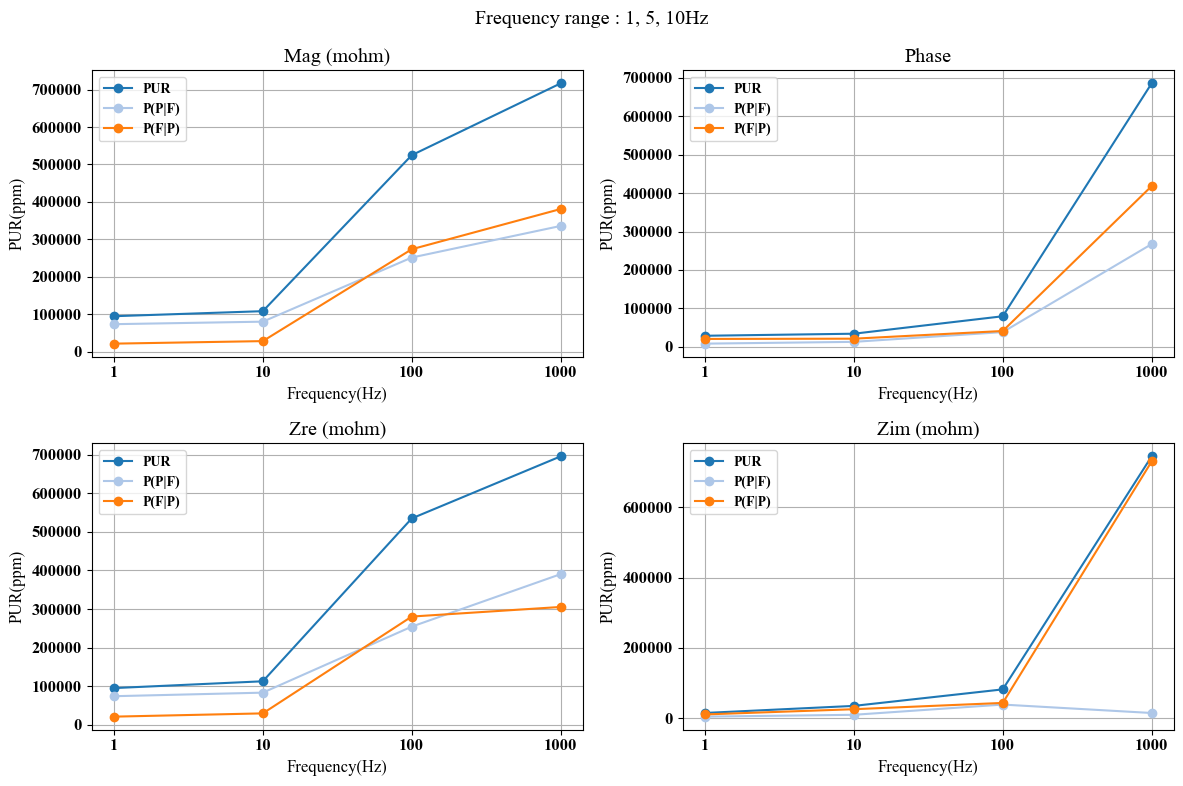

In [38]:
# PUR Visualization as ppm unit
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
fig.suptitle("Frequency range : 1, 5, 10Hz")
label = ["PUR", "P(P|F)", "P(F|P)"]
features_per_plot = 3
num_plots = len(inter_df_col[1:]) // features_per_plot
for i in range(num_plots):
    row = int(i / 2)
    col = i % 2
    start_idx = i * features_per_plot
    end_idx = start_idx + features_per_plot

    for l, ft in enumerate(inter_df_col[start_idx + 1:end_idx + 1]):
        axs[row][col].plot(list(intersection_eis_kde_df.index[:]), intersection_eis_kde_df[ft][:] * np.array(1.0e6), "o-",label=label[l])

    axs[row][col].set_title(inter_df_col[end_idx-2])
    axs[row][col].set_xlabel("Frequency(Hz)")
    axs[row][col].set_ylabel("PUR(ppm)")
    axs[row][col].set_xticks(ticks=[list(intersection_eis_kde_df.index)[i] for i in [0, 1, 2, 3]], labels=[1, 10, 100, 1000])
    # axs[row][col].set_yticks(np.arange(0,100,10))
    axs[row][col].legend(loc="upper left", fontsize=10)  # 각 피처에 대한 범례 추가
plt.tight_layout()

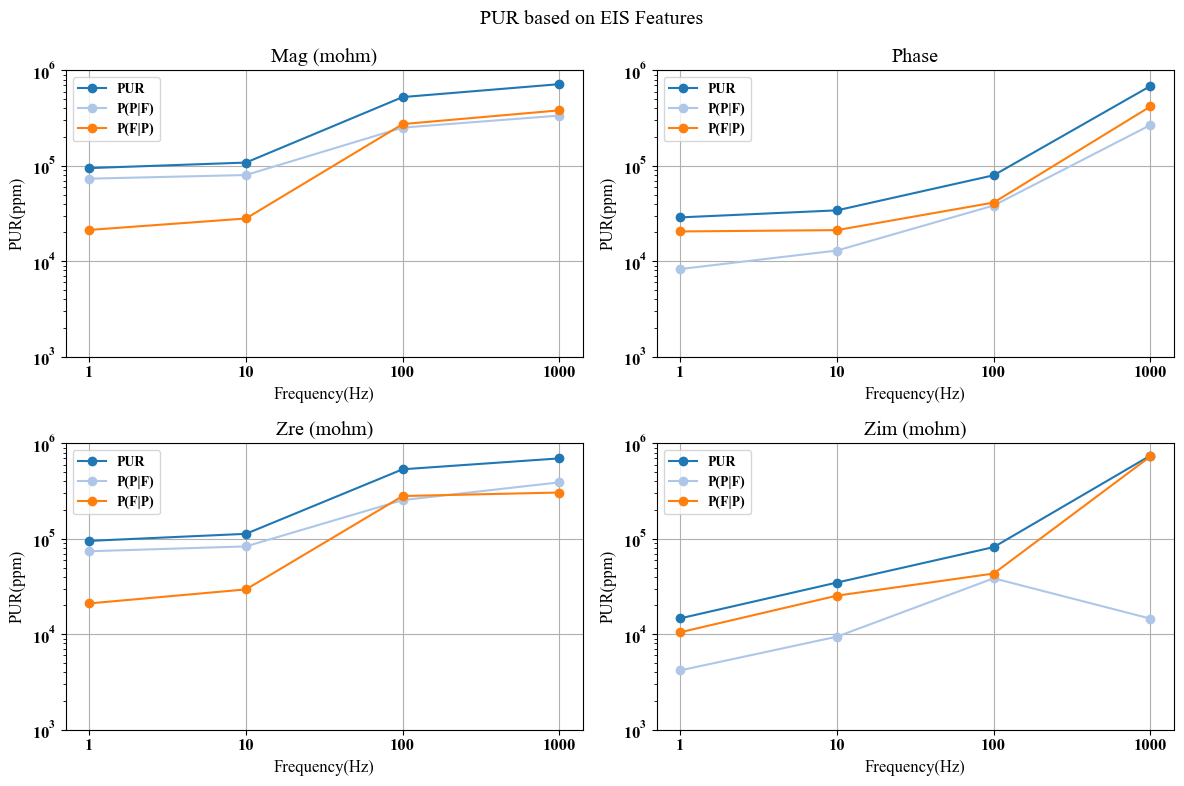

In [39]:
# PUR Visualization as log scale
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
fig.suptitle("PUR based on EIS Features")
label = ["PUR", "P(P|F)", "P(F|P)"]
features_per_plot = 3
num_plots = len(inter_df_col[1:]) // features_per_plot
for i in range(num_plots):
    row = int(i / 2)
    col = i % 2
    start_idx = i * features_per_plot
    end_idx = start_idx + features_per_plot
    for l, ft in enumerate(inter_df_col[start_idx + 1:end_idx + 1]):
        axs[row][col].plot(
            list(intersection_eis_kde_df.index[:]),
            intersection_eis_kde_df[ft][:] * np.array(1.0e6),
            "o-",
            label=label[l],)
    axs[row][col].set_title(inter_df_col[end_idx - 2])
    axs[row][col].set_xlabel("Frequency(Hz)")
    axs[row][col].set_ylabel("PUR(ppm)")
    axs[row][col].set_xticks(ticks=[list(intersection_eis_kde_df.index)[i] for i in [0, 1, 2, 3]], labels=[1, 10, 100, 1000])
    # Y축에만 로그 스케일 적용
    axs[row][col].set_yscale("log")
    axs[row][col].set_ylim([1.0e3, 1.0e6])
    axs[row][col].legend(loc="upper left", fontsize=10)
plt.tight_layout()

##### PDF(Probability Density Function)

In [ ]:
# Calculate to PUR of OVS, DRT
# 결과를 저장할 딕셔너리 생성
intersection_dict = {ft: [] for ft in inf_cols}
left_dict = {ft: [] for ft in inf_cols}
right_dict = {ft: [] for ft in inf_cols}

sdf_draw_df_0 = snd_inf_df[snd_inf_df["P/F"] == 0]
sdf_draw_df_1 = snd_inf_df[snd_inf_df["P/F"] == 1]

# 각 피처에 대해 PDF 생성 및 적분 계산
for i, ft in enumerate(inf_cols):
    dummy_draw_0 = sdf_draw_df_0[ft]
    dummy_draw_1 = sdf_draw_df_1[ft]

    # PDF 기반 연속확률밀도 계산
    min_val = min(dummy_draw_0.min(), dummy_draw_1.min())
    max_val = max(dummy_draw_0.max(), dummy_draw_1.max())
    x_vals = np.linspace(min_val, max_val, 1000)

    # PDF 계산
    pdf_0_vals = norm.pdf(x_vals, loc=dummy_draw_0.mean(), scale=dummy_draw_0.std())
    pdf_1_vals = norm.pdf(x_vals, loc=dummy_draw_1.mean(), scale=dummy_draw_1.std())

    # 교차 지점 찾기
    difference = pdf_0_vals - pdf_1_vals
    intersection_indices = np.where(np.diff(np.sign(difference)))[0]

    if len(intersection_indices) > 0:
        intersection_index = intersection_indices[0]

        # 교차 지점 이전 (왼쪽) 영역 적분
        x_vals_left = x_vals[:intersection_index + 1]
        min_pdf_vals_left = np.minimum(pdf_0_vals[:intersection_index + 1], pdf_1_vals[:intersection_index + 1])
        left_area = integrate.simpson(min_pdf_vals_left, x=x_vals_left)
        left_dict[ft].append(left_area)

        # 교차 지점 이후 (오른쪽) 영역 적분
        x_vals_right = x_vals[intersection_index:]
        min_pdf_vals_right = np.minimum(pdf_0_vals[intersection_index:], pdf_1_vals[intersection_index:])
        right_area = integrate.simpson(min_pdf_vals_right, x=x_vals_right)
        right_dict[ft].append(right_area)

        # 전체 교차 영역 적분
        intersection_area = left_area + right_area
        intersection_dict[ft].append(intersection_area)
    else:
        # 교차 지점이 없는 경우, 전체 영역을 적분
        intersection_area = integrate.simpson(np.minimum(pdf_0_vals, pdf_1_vals), x=x_vals)
        intersection_dict[ft].append(intersection_area)
        left_dict[ft].append(0)  # 교차 지점이 없으므로 왼쪽, 오른쪽이 없음
        right_dict[ft].append(0)

# 데이터프레임 생성
intersection_ind_pdf_df = pd.DataFrame.from_dict(intersection_dict, orient='index').transpose()
left_df = pd.DataFrame.from_dict(left_dict, orient='index').transpose()
right_df = pd.DataFrame.from_dict(right_dict, orient='index').transpose()

# left와 right를 intersection_ind_pdf_df에 추가
intersection_ind_pdf_df = pd.concat([intersection_ind_pdf_df, left_df.add_prefix("Left_"), right_df.add_prefix("Right_")], axis=1)
intersection_ind_pdf_df*np.array(1.0e6)
intersection_ind_kde_df.iloc[:, :2]*np.array(1.0e6) - intersection_ind_pdf_df.iloc[:, :2]*np.array(1.0e6)

,OCV-B,Max Gamma
0,3727.505095,14981.356545


In [42]:
# Calculate to PUR of EIS Features
# 결과 저장용 딕셔너리 초기화
intersection_dict = {ft: [] for ft in eis_ft_cols}
left_dict = {ft: [] for ft in eis_ft_cols}
right_dict = {ft: [] for ft in eis_ft_cols}

# PDF 기반 적분 계산
for f in f_df_list:
    # 데이터 분리
    sdf_draw_df_0 = snd_df[f][snd_df[f]["P/F"] == 0]  # P/F == 0
    sdf_draw_df_1 = snd_df[f][snd_df[f]["P/F"] == 1]  # P/F == 1

    # 각 피처에 대해 PDF 생성 및 적분 계산
    for ft in eis_ft_cols:
        dummy_draw_0 = sdf_draw_df_0[ft]
        dummy_draw_1 = sdf_draw_df_1[ft]

        # PDF 기반 확률밀도 계산
        min_val = min(dummy_draw_0.min(), dummy_draw_1.min())
        max_val = max(dummy_draw_0.max(), dummy_draw_1.max())
        x_vals = np.linspace(min_val, max_val, 1000)

        pdf_0_vals = norm.pdf(x_vals, loc=dummy_draw_0.mean(), scale=dummy_draw_0.std())
        pdf_1_vals = norm.pdf(x_vals, loc=dummy_draw_1.mean(), scale=dummy_draw_1.std())

        # 교차 지점 찾기
        difference = pdf_0_vals - pdf_1_vals
        intersection_indices = np.where(np.diff(np.sign(difference)))[0]

        if len(intersection_indices) > 0:
            intersection_index = intersection_indices[0]

            # 교차 지점 이전 (왼쪽) 영역 적분
            x_vals_left = x_vals[:intersection_index + 1]
            min_pdf_vals_left = np.minimum(pdf_0_vals[:intersection_index + 1], pdf_1_vals[:intersection_index + 1])
            left_area = integrate.simpson(min_pdf_vals_left, x=x_vals_left)
            left_dict[ft].append(left_area)

            # 교차 지점 이후 (오른쪽) 영역 적분
            x_vals_right = x_vals[intersection_index:]
            min_pdf_vals_right = np.minimum(pdf_0_vals[intersection_index:], pdf_1_vals[intersection_index:])
            right_area = integrate.simpson(min_pdf_vals_right, x=x_vals_right)
            right_dict[ft].append(right_area)

            # 전체 교차 영역 적분
            intersection_area = left_area + right_area
            intersection_dict[ft].append(intersection_area)
        else:
            # 교차 지점이 없는 경우, 전체 영역을 적분
            intersection_area = integrate.simpson(np.minimum(pdf_0_vals, pdf_1_vals), x=x_vals)
            intersection_dict[ft].append(intersection_area)
            left_dict[ft].append(0)  # 교차 지점이 없으므로 왼쪽, 오른쪽 없음
            right_dict[ft].append(0)

# 교차 영역 결과를 데이터프레임으로 변환
intersection_eis_pdf_df = pd.DataFrame.from_dict(intersection_dict, orient='index').transpose()

# left_dict와 right_dict를 데이터프레임으로 변환
left_df = pd.DataFrame.from_dict(left_dict, orient='index').transpose()
right_df = pd.DataFrame.from_dict(right_dict, orient='index').transpose()

# intersection_eis_pdf_df에 왼쪽(left)과 오른쪽(right) 적분 값을 추가
intersection_eis_pdf_df = pd.concat([intersection_eis_pdf_df, left_df.add_prefix("Left_"), right_df.add_prefix("Right_")], axis=1)
intersection_eis_pdf_df = pd.concat([intersection_eis_pdf_df, pd.DataFrame([1, 10, 100, 1000], columns=["Frequency"])], axis=1)
intersection_eis_pdf_df = intersection_eis_pdf_df[inter_df_col]
intersection_eis_pdf_df

,Frequency,Mag (mohm),Left_Mag (mohm),Right_Mag (mohm),Phase,Left_Phase,Right_Phase,Zre (mohm),Left_Zre (mohm),Right_Zre (mohm),Zim (mohm),Left_Zim (mohm),Right_Zim (mohm)
0,1,0.051145,0.033808,0.017337,0.020753,0.007773,0.012980,0.051411,0.033898,0.017513,0.017195,0.005180,0.012015
1,10,0.057777,0.036237,0.021540,0.026927,0.008556,0.018372,0.060694,0.038194,0.022499,0.026335,0.007477,0.018857
2,100,0.512089,0.280931,0.231158,0.039465,0.014939,0.024527,0.523981,0.285566,0.238414,0.040471,0.014827,0.025644
3,1000,0.864116,0.344093,0.520023,0.684480,0.309980,0.374501,0.680926,0.417196,0.263730,0.880750,0.105259,0.775491


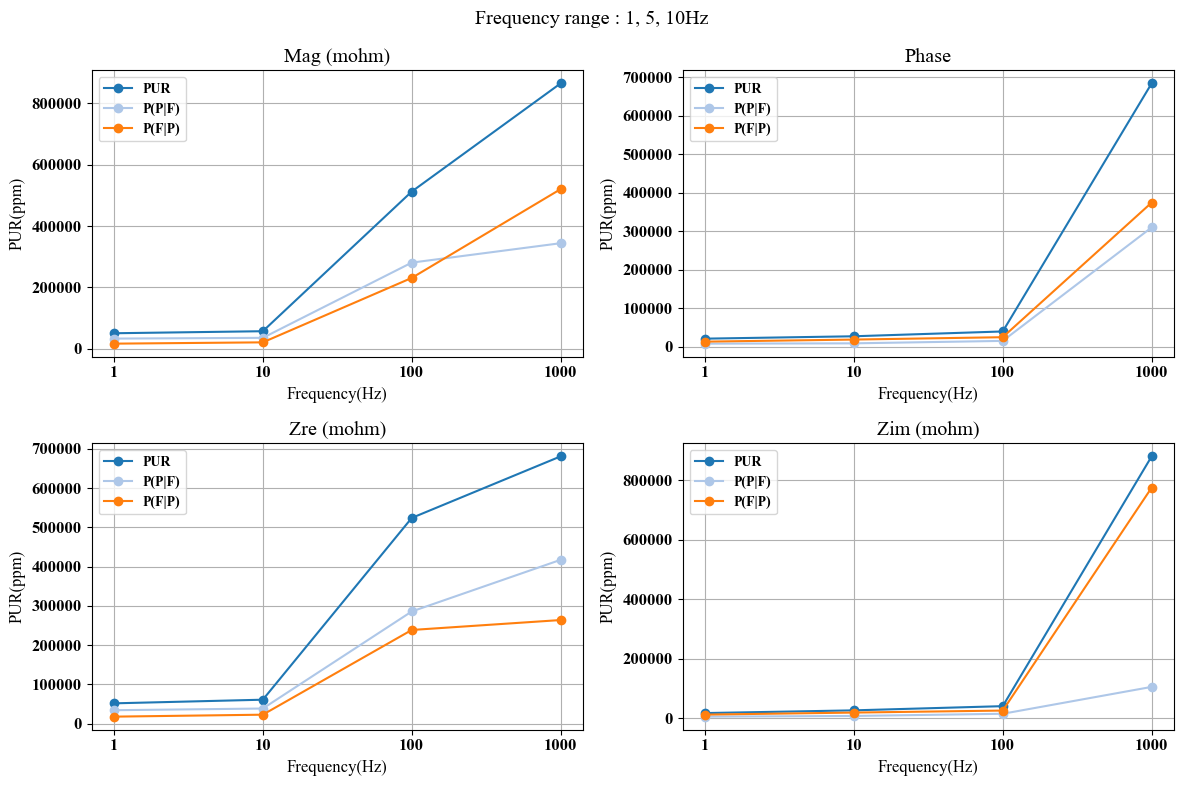

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
fig.suptitle("Frequency range : 1, 5, 10Hz")
label = ["PUR", "P(P|F)", "P(F|P)"]
features_per_plot = 3
num_plots = len(inter_df_col[1:]) // features_per_plot
for i in range(num_plots):
    row = int(i / 2)
    col = i % 2
    start_idx = i * features_per_plot
    end_idx = start_idx + features_per_plot

    for l, ft in enumerate(inter_df_col[start_idx + 1:end_idx + 1]):
        axs[row][col].plot(list(intersection_eis_pdf_df.index[:]), intersection_eis_pdf_df[ft][:] * np.array(1.0e6), "o-",label=label[l])

    axs[row][col].set_title(inter_df_col[end_idx-2])
    axs[row][col].set_xlabel("Frequency(Hz)")
    axs[row][col].set_ylabel("PUR(ppm)")
    axs[row][col].set_xticks(ticks=[list(intersection_eis_pdf_df.index)[i] for i in [0, 1, 2, 3]], labels=[1, 10, 100, 1000])
    # axs[row][col].set_yticks(np.arange(0,100,10))
    axs[row][col].legend(loc="upper left", fontsize=10)  # 각 피처에 대한 범례 추가
plt.tight_layout()

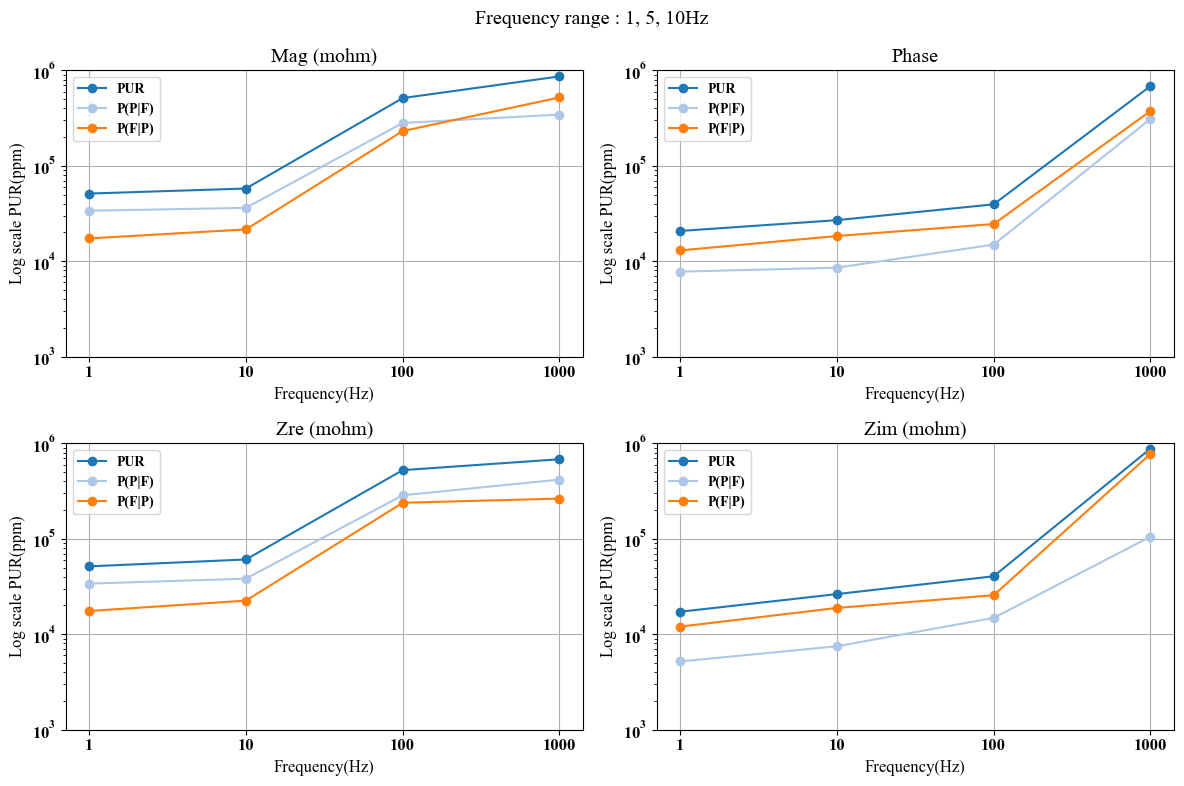

In [44]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
fig.suptitle("Frequency range : 1, 5, 10Hz")
label = ["PUR", "P(P|F)", "P(F|P)"]
features_per_plot = 3
num_plots = len(inter_df_col[1:]) // features_per_plot
for i in range(num_plots):
    row = int(i / 2)
    col = i % 2
    start_idx = i * features_per_plot
    end_idx = start_idx + features_per_plot
    for l, ft in enumerate(inter_df_col[start_idx + 1:end_idx + 1]):
        axs[row][col].plot(
            list(intersection_eis_pdf_df.index[:]),
            intersection_eis_pdf_df[ft][:] * np.array(1.0e6),
            "o-",
            label=label[l],)
    axs[row][col].set_title(inter_df_col[end_idx - 2])
    axs[row][col].set_xlabel("Frequency(Hz)")
    axs[row][col].set_ylabel("Log scale PUR(ppm)")
    axs[row][col].set_xticks(ticks=[list(intersection_eis_pdf_df.index)[i] for i in [0, 1, 2, 3]], labels=[1, 10, 100, 1000])
    # Y축에만 로그 스케일 적용
    axs[row][col].set_yscale("log")
    axs[row][col].set_ylim([1.0e3, 1.0e6])
    axs[row][col].legend(loc="upper left", fontsize=10)
plt.tight_layout()

##### Comparison by methods

,Zre (mohm),Zim (mohm),Mag (mohm),Phase
0,51410.958756,17195.053666,51144.988819,20753.113587
1,60693.786553,26334.688047,57777.357973,26927.429607
2,523980.603678,40471.312132,512088.898074,39465.350298
3,680926.395108,880749.526596,864116.303030,684480.465520


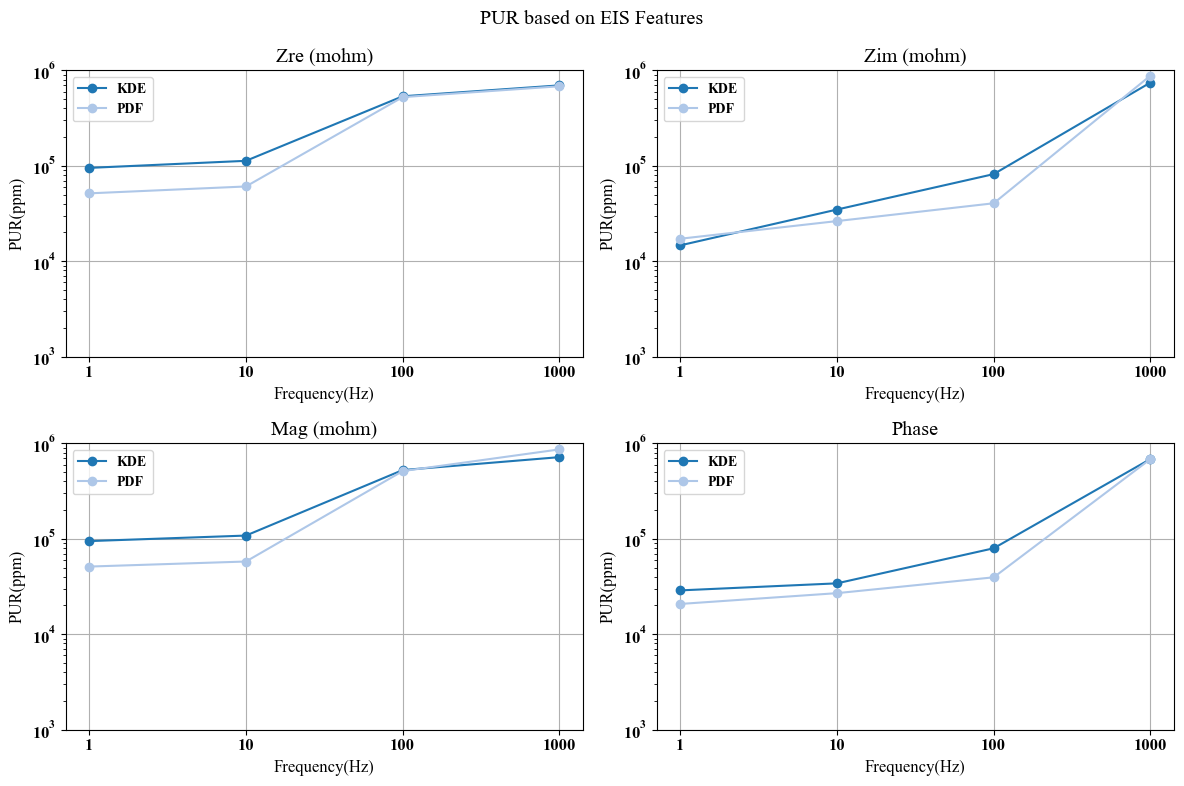

In [ ]:
compare_pur_kde = intersection_eis_kde_df[eis_ft_cols]
compare_pur_pdf = intersection_eis_pdf_df[eis_ft_cols]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
fig.suptitle("PUR based on EIS Features")
features_per_plot = 1
num_plots = len(inter_df_col[1:]) // features_per_plot
for i, ft in enumerate(eis_ft_cols):
    row = int(i / 2)
    col = i % 2
    axs[row][col].plot(list(intersection_eis_pdf_df.index[:]),compare_pur_kde[ft][:] * np.array(1.0e6),"o-",label="KDE")
    axs[row][col].plot(list(intersection_eis_kde_df.index[:]),compare_pur_pdf[ft][:] * np.array(1.0e6),"o-",label="PDF")
    axs[row][col].set_title(ft)
    axs[row][col].set_xlabel("Frequency(Hz)")
    axs[row][col].set_ylabel("PUR(ppm)")
    axs[row][col].set_xticks(ticks=[list(intersection_eis_pdf_df.index)[i] for i in [0, 1, 2, 3]], labels=[1, 10, 100, 1000])
    # Y축에만 로그 스케일 적용
    axs[row][col].set_yscale("log")
    axs[row][col].set_ylim([1.0e3, 1.0e6])
    axs[row][col].legend(loc="upper left", fontsize=10)
plt.tight_layout()

(compare_pur_kde)*np.array(1.0e6)
(compare_pur_pdf)*np.array(1.0e6)